# Introduction

Credit card fraud is a major financial threat worldwide, causing billions of dollars in losses every year. Detecting fraudulent transactions is challenging because fraud cases are extremely rare and often hidden within a massive volume of legitimate transactions. Traditional classification models struggle with such highly imbalanced data.

In this project, we use an Autoencoder-based anomaly detection approach to identify unusual credit card transactions. Autoencoders are trained only on normal transaction data, allowing the model to learn the underlying patterns of legitimate behavior. When an abnormal or fraudulent transaction is passed through the network, it produces a higher reconstruction error, allowing us to flag it as suspicious.

This unsupervised learning method is powerful for fraud detection because it does not require large amounts of labeled fraud data and performs well even when the dataset is highly imbalanced.

In [1]:
import pandas as pd
import numpy as np
import pickle
import matplotlib.pyplot as plt
from scipy import stats
import tensorflow as tf
import seaborn as sns
from pylab import rcParams
from sklearn.model_selection import train_test_split
from keras.models import Model, load_model
from keras.layers import Input, Dense
from keras.callbacks import ModelCheckpoint, TensorBoard
from keras import regularizers

%matplotlib inline

sns.set(style='whitegrid', palette='muted', font_scale=1.5)

rcParams['figure.figsize'] = 14, 8

RANDOM_SEED = 42
LABELS = ["Normal", "Fraud"]

# Loading the data

The dataset we're going to use can be downloaded from [Kaggle](https://www.kaggle.com/dalpozz/creditcardfraud). It contains data about credit card transactions that occurred during a period of two days, with 492 frauds out of 284,807 transactions.

All variables in the dataset are numerical. The data has been transformed using PCA transformation(s) due to privacy reasons. The two features that haven't been changed are Time and Amount. Time contains the seconds elapsed between each transaction and the first transaction in the dataset.

In [3]:
df = pd.read_csv("data/creditcard.csv")


# Exploration

In [4]:
df.shape

(284807, 31)

31 columns, 2 of which are Time and Amount. The rest are output from the PCA transformation. Let's check for missing values:

In [5]:
df.isnull().values.any()

False

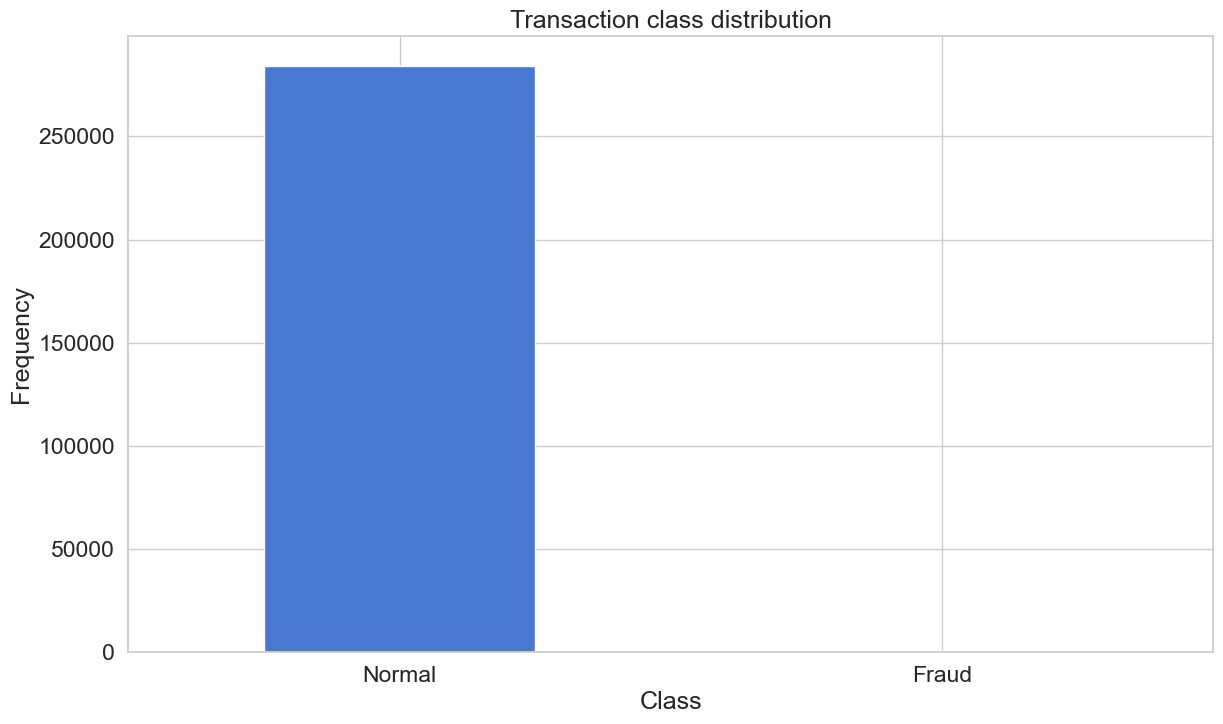

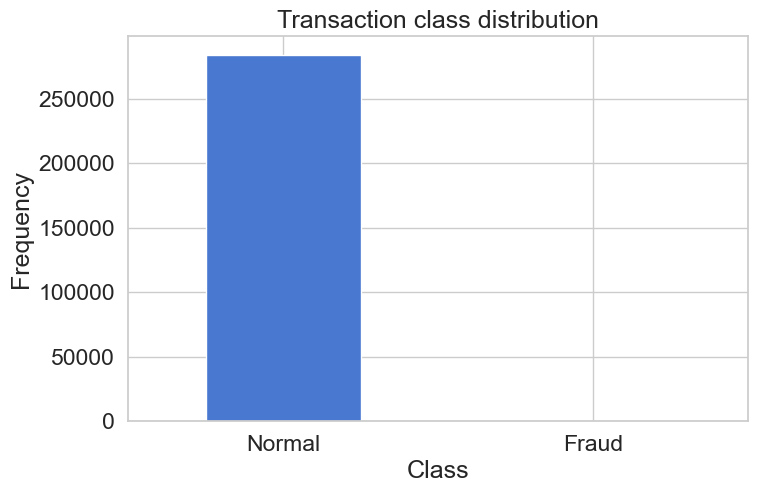

In [9]:
count_classes = df['Class'].value_counts()

plt.figure(figsize=(8,5))
count_classes.plot(kind='bar', rot=0)
plt.title("Transaction class distribution")
plt.xticks(range(2), LABELS)
plt.xlabel("Class")
plt.ylabel("Frequency")
plt.show()


We have a highly imbalanced dataset on our hands. Normal transactions overwhelm the fraudulent ones by a large margin. Let's look at the two types of transactions: 

In [10]:
frauds = df[df.Class == 1]
normal = df[df.Class == 0]

In [11]:
frauds.shape

(492, 31)

In [8]:
normal.shape

(284315, 31)

How different are the amount of money used in different transaction classes?

In [12]:
frauds.Amount.describe()

count     492.000000
mean      122.211321
std       256.683288
min         0.000000
25%         1.000000
50%         9.250000
75%       105.890000
max      2125.870000
Name: Amount, dtype: float64

In [13]:
normal.Amount.describe()

count    284315.000000
mean         88.291022
std         250.105092
min           0.000000
25%           5.650000
50%          22.000000
75%          77.050000
max       25691.160000
Name: Amount, dtype: float64

Let's have a more graphical representation:

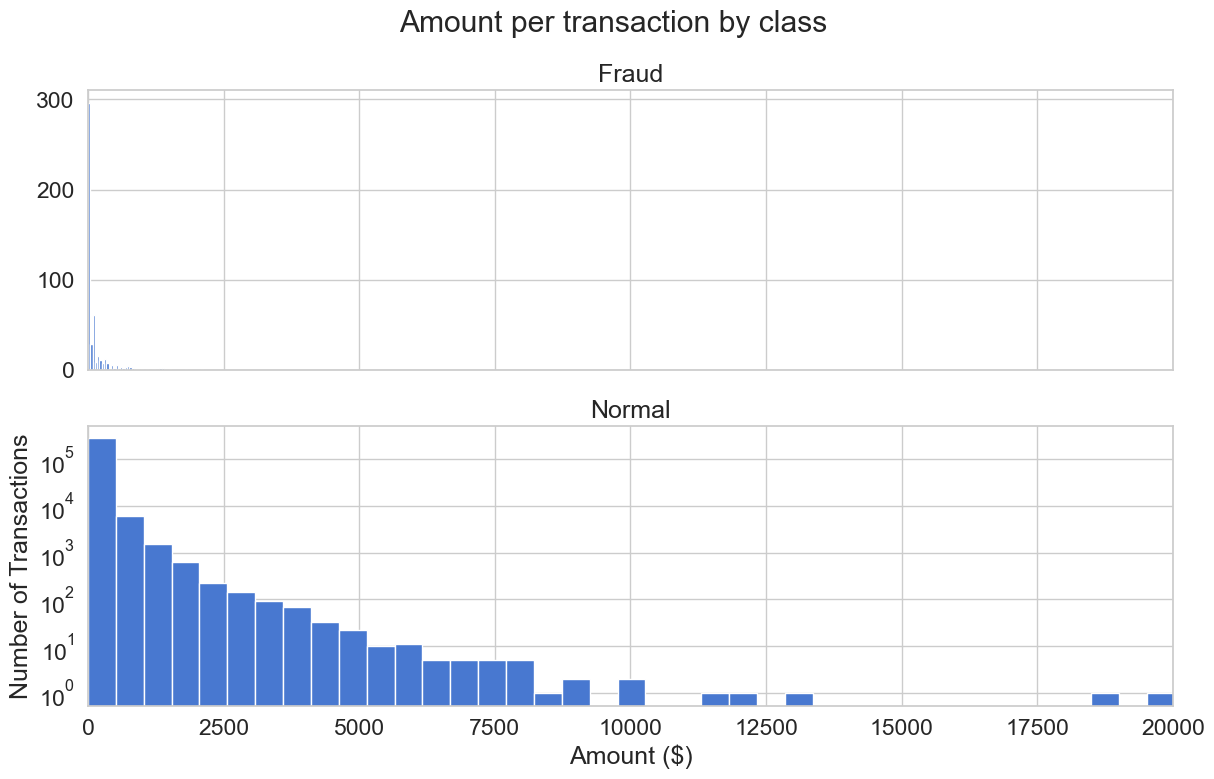

In [14]:
f, (ax1, ax2) = plt.subplots(2, 1, sharex=True)
f.suptitle('Amount per transaction by class')

bins = 50

ax1.hist(frauds.Amount, bins = bins)
ax1.set_title('Fraud')

ax2.hist(normal.Amount, bins = bins)
ax2.set_title('Normal')

plt.xlabel('Amount ($)')
plt.ylabel('Number of Transactions')
plt.xlim((0, 20000))
plt.yscale('log')
plt.show();

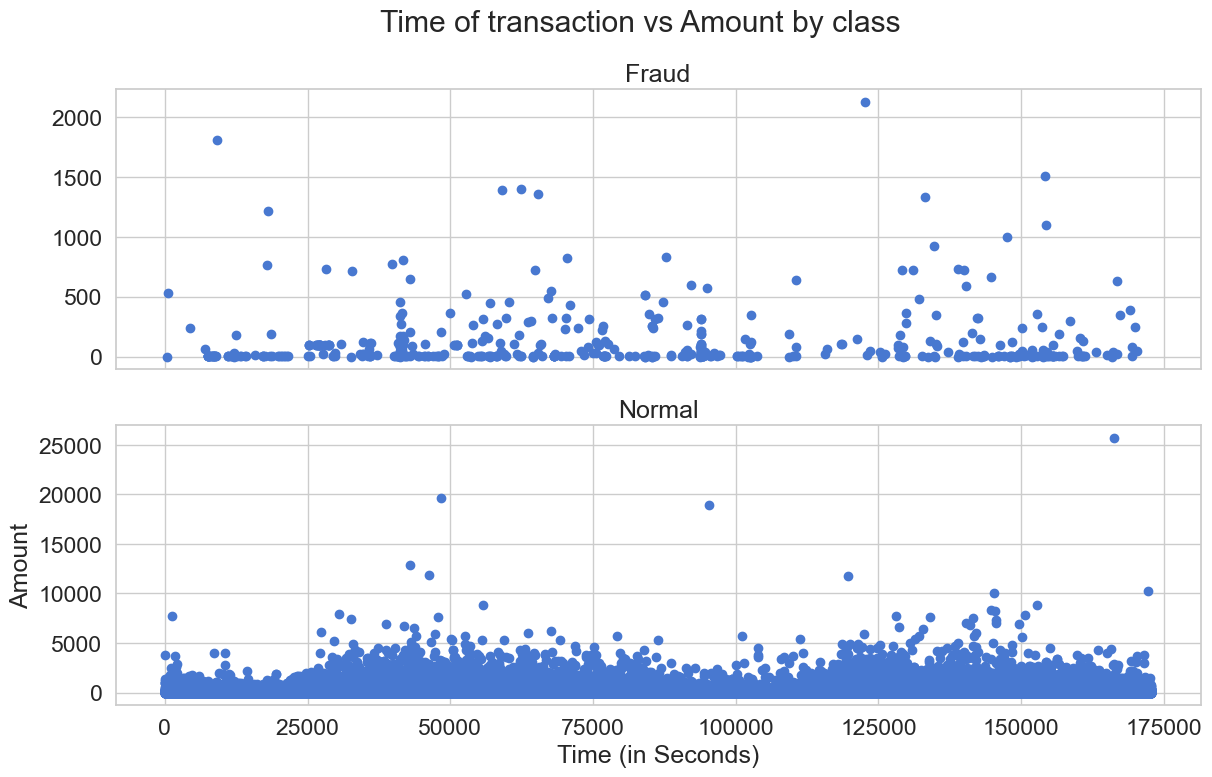

In [15]:
f, (ax1, ax2) = plt.subplots(2, 1, sharex=True)
f.suptitle('Time of transaction vs Amount by class')

ax1.scatter(frauds.Time, frauds.Amount)
ax1.set_title('Fraud')

ax2.scatter(normal.Time, normal.Amount)
ax2.set_title('Normal')

plt.xlabel('Time (in Seconds)')
plt.ylabel('Amount')
plt.show()

# Preparing the data

First, let's drop the Time column (not going to use it) and use the scikit's StandardScaler on the Amount. The scaler removes the mean and scales the values to unit variance:

In [16]:
from sklearn.preprocessing import StandardScaler

data = df.drop(['Time'], axis=1)

data['Amount'] = StandardScaler().fit_transform(data['Amount'].values.reshape(-1, 1))

Training our Autoencoder is gonna be a bit different from what we are used to. Let's say you have a dataset containing a lot of non fraudulent transactions at hand. You want to detect any anomaly on new transactions. We will create this situation by training our model on the normal transactions, only. Reserving the correct class on the test set will give us a way to evaluate the performance of our model. We will reserve 20% of our data for testing:

In [17]:
X_train, X_test = train_test_split(data, test_size=0.2, random_state=RANDOM_SEED)
X_train = X_train[X_train.Class == 0]
X_train = X_train.drop(['Class'], axis=1)

y_test = X_test['Class']
X_test = X_test.drop(['Class'], axis=1)

X_train = X_train.values
X_test = X_test.values

In [18]:
X_train.shape

(227451, 29)

# Building the model

Our Autoencoder uses 4 fully connected layers with 14, 7, 7 and 29 neurons respectively.  The first two layers are used for our encoder, the last two go for the decoder. Additionally, L1 regularization will be used during training:

In [19]:
input_dim = X_train.shape[1]
encoding_dim = 14

In [20]:
input_layer = Input(shape=(input_dim, ))

encoder = Dense(encoding_dim, activation="tanh", 
                activity_regularizer=regularizers.l1(10e-5))(input_layer)
encoder = Dense(int(encoding_dim / 2), activation="relu")(encoder)

decoder = Dense(int(encoding_dim / 2), activation='tanh')(encoder)
decoder = Dense(input_dim, activation='relu')(decoder)

autoencoder = Model(inputs=input_layer, outputs=decoder)

Let's train our model for 100 epochs with a batch size of 32 samples and save the best performing model to a file. The ModelCheckpoint provided by Keras is really handy for such tasks. Additionally,  the training progress will be exported in a format that TensorBoard understands.

In [21]:
nb_epoch = 100
batch_size = 32

autoencoder.compile(optimizer='adam', 
                    loss='mean_squared_error', 
                    metrics=['accuracy'])

checkpointer = ModelCheckpoint(filepath="model.h5",
                               verbose=0,
                               save_best_only=True)
tensorboard = TensorBoard(log_dir='./logs',
                          histogram_freq=0,
                          write_graph=True,
                          write_images=True)

history = autoencoder.fit(X_train, X_train,
                    epochs=nb_epoch,
                    batch_size=batch_size,
                    shuffle=True,
                    validation_data=(X_test, X_test),
                    verbose=1,
                    callbacks=[checkpointer, tensorboard]).history

Epoch 1/100
7089/7108 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4490 - loss: 0.8990

7108/7108 ━━━━━━━━━━━━━━━━━━━━ 18s 2ms/step - accuracy: 0.5588 - loss: 0.8426 - val_accuracy: 0.6487 - val_loss: 0.8141
Epoch 2/100
7095/7108 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6589 - loss: 0.7961

7108/7108 ━━━━━━━━━━━━━━━━━━━━ 17s 2ms/step - accuracy: 0.6613 - loss: 0.7776 - val_accuracy: 0.6657 - val_loss: 0.8002
Epoch 3/100
7085/7108 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6665 - loss: 0.7819

7108/7108 ━━━━━━━━━━━━━━━━━━━━ 17s 2ms/step - accuracy: 0.6678 - loss: 0.7693 - val_accuracy: 0.6648 - val_loss: 0.7982
Epoch 4/100
7104/7108 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6676 - loss: 0.7697

7108/7108 ━━━━━━━━━━━━━━━━━━━━ 28s 4ms/step - accuracy: 0.6693 - loss: 0.7666 - val_accuracy: 0.6726 - val_loss: 0.7935
Epoch 5/100
7108/7108 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6686 - loss: 0.7729

7108/7108 ━━━━━━━━━━━━━━━━━━━━ 28s 4ms/step - accuracy: 0.6704 - loss: 0.7647 - val_accuracy: 0.6667 - val_loss: 0.7923
Epoch 6/100
7106/7108 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6710 - loss: 0.7640

7108/7108 ━━━━━━━━━━━━━━━━━━━━ 41s 4ms/step - accuracy: 0.6707 - loss: 0.7633 - val_accuracy: 0.6714 - val_loss: 0.7916
Epoch 7/100
7095/7108 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6715 - loss: 0.7851

7108/7108 ━━━━━━━━━━━━━━━━━━━━ 16s 2ms/step - accuracy: 0.6704 - loss: 0.7611 - val_accuracy: 0.6651 - val_loss: 0.7903
Epoch 8/100
7085/7108 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6718 - loss: 0.7610

7108/7108 ━━━━━━━━━━━━━━━━━━━━ 17s 2ms/step - accuracy: 0.6713 - loss: 0.7596 - val_accuracy: 0.6676 - val_loss: 0.7878
Epoch 9/100
7108/7108 ━━━━━━━━━━━━━━━━━━━━ 33s 5ms/step - accuracy: 0.6710 - loss: 0.7577 - val_accuracy: 0.6693 - val_loss: 0.7884
Epoch 10/100
7100/7108 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6731 - loss: 0.7818

7108/7108 ━━━━━━━━━━━━━━━━━━━━ 27s 4ms/step - accuracy: 0.6716 - loss: 0.7565 - val_accuracy: 0.6733 - val_loss: 0.7853
Epoch 11/100
7095/7108 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.6722 - loss: 0.7630

7108/7108 ━━━━━━━━━━━━━━━━━━━━ 44s 6ms/step - accuracy: 0.6720 - loss: 0.7557 - val_accuracy: 0.6764 - val_loss: 0.7853
Epoch 12/100
7096/7108 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6737 - loss: 0.7541

7108/7108 ━━━━━━━━━━━━━━━━━━━━ 18s 2ms/step - accuracy: 0.6734 - loss: 0.7549 - val_accuracy: 0.6776 - val_loss: 0.7852
Epoch 13/100
7108/7108 ━━━━━━━━━━━━━━━━━━━━ 16s 2ms/step - accuracy: 0.6731 - loss: 0.7545 - val_accuracy: 0.6593 - val_loss: 0.7893
Epoch 14/100
7097/7108 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6749 - loss: 0.7590

7108/7108 ━━━━━━━━━━━━━━━━━━━━ 18s 3ms/step - accuracy: 0.6744 - loss: 0.7538 - val_accuracy: 0.6772 - val_loss: 0.7827
Epoch 15/100
7101/7108 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6765 - loss: 0.7649

7108/7108 ━━━━━━━━━━━━━━━━━━━━ 21s 3ms/step - accuracy: 0.6760 - loss: 0.7534 - val_accuracy: 0.6789 - val_loss: 0.7827
Epoch 16/100
7086/7108 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6775 - loss: 0.7452

7108/7108 ━━━━━━━━━━━━━━━━━━━━ 19s 3ms/step - accuracy: 0.6762 - loss: 0.7529 - val_accuracy: 0.6777 - val_loss: 0.7826
Epoch 17/100
7104/7108 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6777 - loss: 0.7336

7108/7108 ━━━━━━━━━━━━━━━━━━━━ 17s 2ms/step - accuracy: 0.6768 - loss: 0.7528 - val_accuracy: 0.6759 - val_loss: 0.7817
Epoch 18/100
7087/7108 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6758 - loss: 0.7665

7108/7108 ━━━━━━━━━━━━━━━━━━━━ 16s 2ms/step - accuracy: 0.6763 - loss: 0.7522 - val_accuracy: 0.6813 - val_loss: 0.7807
Epoch 19/100
7108/7108 ━━━━━━━━━━━━━━━━━━━━ 17s 2ms/step - accuracy: 0.6760 - loss: 0.7522 - val_accuracy: 0.6794 - val_loss: 0.7810
Epoch 20/100
7108/7108 ━━━━━━━━━━━━━━━━━━━━ 17s 2ms/step - accuracy: 0.6758 - loss: 0.7523 - val_accuracy: 0.6740 - val_loss: 0.7815
Epoch 21/100
7108/7108 ━━━━━━━━━━━━━━━━━━━━ 21s 2ms/step - accuracy: 0.6760 - loss: 0.7515 - val_accuracy: 0.6753 - val_loss: 0.7834
Epoch 22/100
7108/7108 ━━━━━━━━━━━━━━━━━━━━ 16s 2ms/step - accuracy: 0.6764 - loss: 0.7519 - val_accuracy: 0.6763 - val_loss: 0.7811
Epoch 23/100
7108/7108 ━━━━━━━━━━━━━━━━━━━━ 18s 3ms/step - accuracy: 0.6768 - loss: 0.7515 - val_accuracy: 0.6779 - val_loss: 0.7823
Epoch 24/100
7108/7108 ━━━━━━━━━━━━━━━━━━━━ 20s 3ms/step - accuracy: 0.6773 - loss: 0.7515 - val_accuracy: 0.6791 - val_loss: 0.7854
Epoch 25/100
7089/7108 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6776 - loss:

7108/7108 ━━━━━━━━━━━━━━━━━━━━ 18s 3ms/step - accuracy: 0.6773 - loss: 0.7514 - val_accuracy: 0.6836 - val_loss: 0.7796
Epoch 26/100
7108/7108 ━━━━━━━━━━━━━━━━━━━━ 17s 2ms/step - accuracy: 0.6778 - loss: 0.7511 - val_accuracy: 0.6806 - val_loss: 0.7814
Epoch 27/100
7108/7108 ━━━━━━━━━━━━━━━━━━━━ 17s 2ms/step - accuracy: 0.6777 - loss: 0.7509 - val_accuracy: 0.6750 - val_loss: 0.7805
Epoch 28/100
7090/7108 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6766 - loss: 0.7492

7108/7108 ━━━━━━━━━━━━━━━━━━━━ 17s 2ms/step - accuracy: 0.6780 - loss: 0.7510 - val_accuracy: 0.6817 - val_loss: 0.7790
Epoch 29/100
7108/7108 ━━━━━━━━━━━━━━━━━━━━ 17s 2ms/step - accuracy: 0.6784 - loss: 0.7510 - val_accuracy: 0.6808 - val_loss: 0.7800
Epoch 30/100
7108/7108 ━━━━━━━━━━━━━━━━━━━━ 15s 2ms/step - accuracy: 0.6790 - loss: 0.7509 - val_accuracy: 0.6828 - val_loss: 0.7807
Epoch 31/100
7108/7108 ━━━━━━━━━━━━━━━━━━━━ 16s 2ms/step - accuracy: 0.6792 - loss: 0.7507 - val_accuracy: 0.6786 - val_loss: 0.7824
Epoch 32/100
7108/7108 ━━━━━━━━━━━━━━━━━━━━ 17s 2ms/step - accuracy: 0.6795 - loss: 0.7507 - val_accuracy: 0.6833 - val_loss: 0.7800
Epoch 33/100
7108/7108 ━━━━━━━━━━━━━━━━━━━━ 17s 2ms/step - accuracy: 0.6794 - loss: 0.7505 - val_accuracy: 0.6808 - val_loss: 0.7806
Epoch 34/100
7108/7108 ━━━━━━━━━━━━━━━━━━━━ 16s 2ms/step - accuracy: 0.6803 - loss: 0.7504 - val_accuracy: 0.6782 - val_loss: 0.7799
Epoch 35/100
7108/7108 ━━━━━━━━━━━━━━━━━━━━ 20s 2ms/step - accuracy: 0.6795 - loss

7108/7108 ━━━━━━━━━━━━━━━━━━━━ 18s 3ms/step - accuracy: 0.6792 - loss: 0.7503 - val_accuracy: 0.6763 - val_loss: 0.7789
Epoch 41/100
7108/7108 ━━━━━━━━━━━━━━━━━━━━ 16s 2ms/step - accuracy: 0.6795 - loss: 0.7503 - val_accuracy: 0.6807 - val_loss: 0.7802
Epoch 42/100
7108/7108 ━━━━━━━━━━━━━━━━━━━━ 16s 2ms/step - accuracy: 0.6794 - loss: 0.7500 - val_accuracy: 0.6815 - val_loss: 0.7800
Epoch 43/100
7108/7108 ━━━━━━━━━━━━━━━━━━━━ 17s 2ms/step - accuracy: 0.6793 - loss: 0.7500 - val_accuracy: 0.6753 - val_loss: 0.7904
Epoch 44/100
7104/7108 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6784 - loss: 0.7537

7108/7108 ━━━━━━━━━━━━━━━━━━━━ 16s 2ms/step - accuracy: 0.6796 - loss: 0.7501 - val_accuracy: 0.6770 - val_loss: 0.7786
Epoch 45/100
7108/7108 ━━━━━━━━━━━━━━━━━━━━ 17s 2ms/step - accuracy: 0.6798 - loss: 0.7499 - val_accuracy: 0.6792 - val_loss: 0.7824
Epoch 46/100
7108/7108 ━━━━━━━━━━━━━━━━━━━━ 18s 2ms/step - accuracy: 0.6794 - loss: 0.7498 - val_accuracy: 0.6828 - val_loss: 0.7817
Epoch 47/100
7108/7108 ━━━━━━━━━━━━━━━━━━━━ 18s 2ms/step - accuracy: 0.6795 - loss: 0.7499 - val_accuracy: 0.6822 - val_loss: 0.7795
Epoch 48/100
7108/7108 ━━━━━━━━━━━━━━━━━━━━ 15s 2ms/step - accuracy: 0.6789 - loss: 0.7496 - val_accuracy: 0.6748 - val_loss: 0.7808
Epoch 49/100
7108/7108 ━━━━━━━━━━━━━━━━━━━━ 17s 2ms/step - accuracy: 0.6790 - loss: 0.7499 - val_accuracy: 0.6740 - val_loss: 0.7838
Epoch 50/100
7108/7108 ━━━━━━━━━━━━━━━━━━━━ 16s 2ms/step - accuracy: 0.6792 - loss: 0.7496 - val_accuracy: 0.6759 - val_loss: 0.7809
Epoch 51/100
7108/7108 ━━━━━━━━━━━━━━━━━━━━ 16s 2ms/step - accuracy: 0.6786 - loss

7108/7108 ━━━━━━━━━━━━━━━━━━━━ 17s 2ms/step - accuracy: 0.6791 - loss: 0.7495 - val_accuracy: 0.6849 - val_loss: 0.7785
Epoch 57/100
7108/7108 ━━━━━━━━━━━━━━━━━━━━ 22s 3ms/step - accuracy: 0.6795 - loss: 0.7494 - val_accuracy: 0.6798 - val_loss: 0.7787
Epoch 58/100
7108/7108 ━━━━━━━━━━━━━━━━━━━━ 16s 2ms/step - accuracy: 0.6797 - loss: 0.7495 - val_accuracy: 0.6799 - val_loss: 0.7800
Epoch 59/100
7108/7108 ━━━━━━━━━━━━━━━━━━━━ 16s 2ms/step - accuracy: 0.6795 - loss: 0.7497 - val_accuracy: 0.6770 - val_loss: 0.7791
Epoch 60/100
7108/7108 ━━━━━━━━━━━━━━━━━━━━ 20s 3ms/step - accuracy: 0.6799 - loss: 0.7496 - val_accuracy: 0.6781 - val_loss: 0.7791
Epoch 61/100
7108/7108 ━━━━━━━━━━━━━━━━━━━━ 26s 4ms/step - accuracy: 0.6791 - loss: 0.7494 - val_accuracy: 0.6820 - val_loss: 0.7800
Epoch 62/100
7108/7108 ━━━━━━━━━━━━━━━━━━━━ 23s 3ms/step - accuracy: 0.6793 - loss: 0.7496 - val_accuracy: 0.6768 - val_loss: 0.7801
Epoch 63/100
7108/7108 ━━━━━━━━━━━━━━━━━━━━ 22s 3ms/step - accuracy: 0.6792 - loss

7108/7108 ━━━━━━━━━━━━━━━━━━━━ 16s 2ms/step - accuracy: 0.6804 - loss: 0.7491 - val_accuracy: 0.6828 - val_loss: 0.7783
Epoch 90/100
7108/7108 ━━━━━━━━━━━━━━━━━━━━ 18s 3ms/step - accuracy: 0.6798 - loss: 0.7488 - val_accuracy: 0.6775 - val_loss: 0.7823
Epoch 91/100
7108/7108 ━━━━━━━━━━━━━━━━━━━━ 15s 2ms/step - accuracy: 0.6806 - loss: 0.7489 - val_accuracy: 0.6823 - val_loss: 0.7795
Epoch 92/100
7108/7108 ━━━━━━━━━━━━━━━━━━━━ 17s 2ms/step - accuracy: 0.6804 - loss: 0.7489 - val_accuracy: 0.6818 - val_loss: 0.7821
Epoch 93/100
7108/7108 ━━━━━━━━━━━━━━━━━━━━ 16s 2ms/step - accuracy: 0.6801 - loss: 0.7490 - val_accuracy: 0.6812 - val_loss: 0.7787
Epoch 94/100
7108/7108 ━━━━━━━━━━━━━━━━━━━━ 18s 2ms/step - accuracy: 0.6800 - loss: 0.7490 - val_accuracy: 0.6852 - val_loss: 0.7789
Epoch 95/100
7087/7108 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6790 - loss: 0.7519

7108/7108 ━━━━━━━━━━━━━━━━━━━━ 17s 2ms/step - accuracy: 0.6791 - loss: 0.7489 - val_accuracy: 0.6852 - val_loss: 0.7779
Epoch 96/100
7108/7108 ━━━━━━━━━━━━━━━━━━━━ 17s 2ms/step - accuracy: 0.6798 - loss: 0.7490 - val_accuracy: 0.6806 - val_loss: 0.7803
Epoch 97/100
7103/7108 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6783 - loss: 0.7505

7108/7108 ━━━━━━━━━━━━━━━━━━━━ 16s 2ms/step - accuracy: 0.6794 - loss: 0.7494 - val_accuracy: 0.6806 - val_loss: 0.7774
Epoch 98/100
7108/7108 ━━━━━━━━━━━━━━━━━━━━ 18s 3ms/step - accuracy: 0.6803 - loss: 0.7489 - val_accuracy: 0.6842 - val_loss: 0.7779
Epoch 99/100
7108/7108 ━━━━━━━━━━━━━━━━━━━━ 19s 3ms/step - accuracy: 0.6795 - loss: 0.7488 - val_accuracy: 0.6797 - val_loss: 0.7793
Epoch 100/100
7108/7108 ━━━━━━━━━━━━━━━━━━━━ 18s 3ms/step - accuracy: 0.6804 - loss: 0.7491 - val_accuracy: 0.6832 - val_loss: 0.7808


In [22]:
autoencoder = load_model('model.h5')

# Evaluation

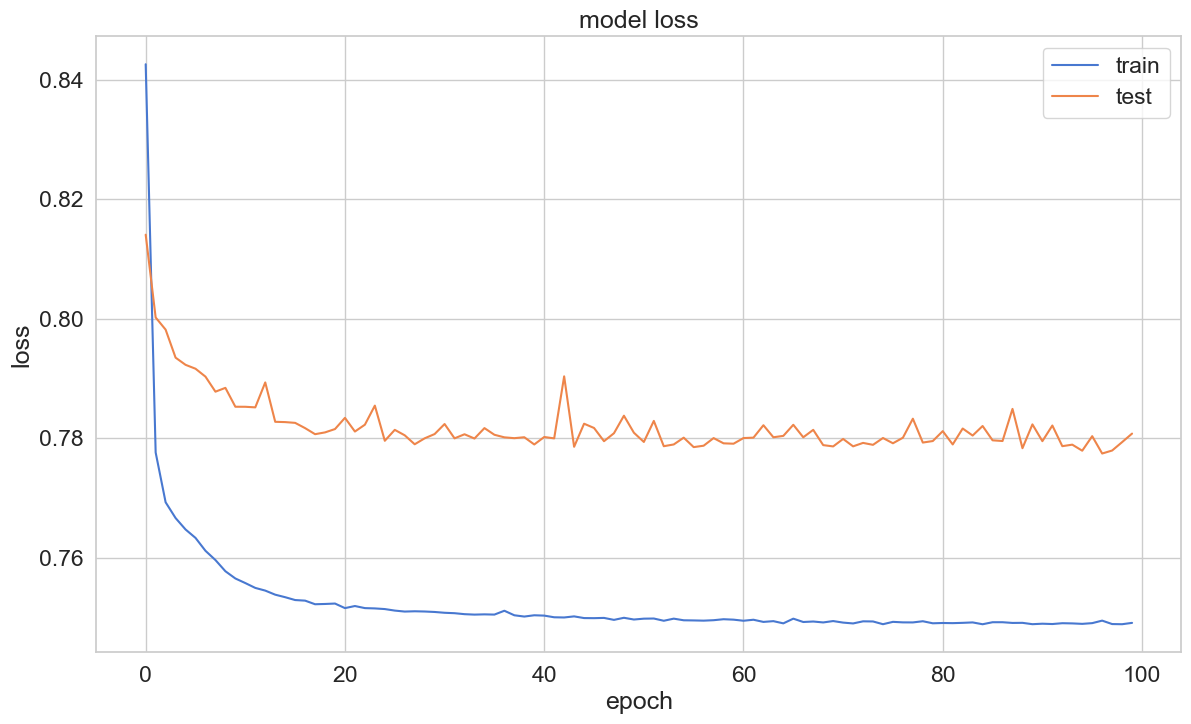

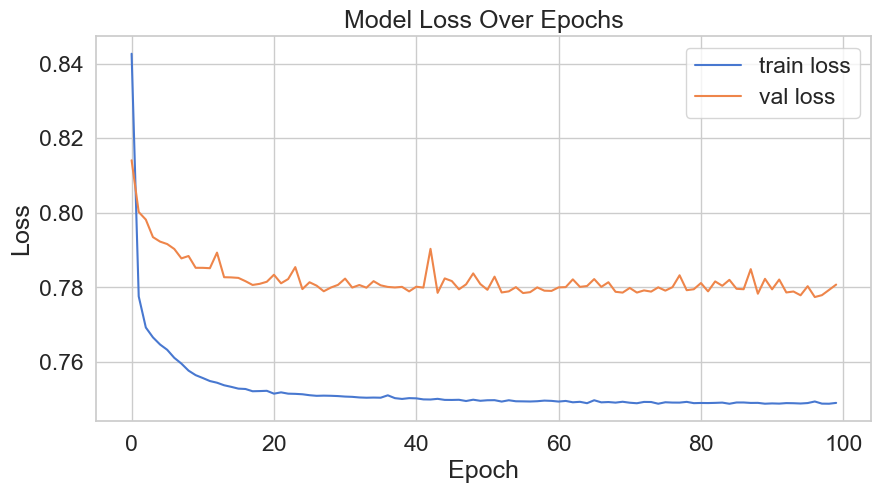

In [24]:
plt.figure(figsize=(10,5))
plt.plot(history['loss'], label='train loss')
plt.plot(history['val_loss'], label='val loss')
plt.title('Model Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()


The reconstruction error on our training and test data seems to converge nicely. Let's have a closer look at the error distribution:

In [25]:
predictions = autoencoder.predict(X_test)

1781/1781 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step


In [26]:
mse = np.mean(np.power(X_test - predictions, 2), axis=1)
error_df = pd.DataFrame({'reconstruction_error': mse,
                         'true_class': y_test})

In [27]:
error_df.describe()

,reconstruction_error,true_class
count,56962.000000,56962.000000
mean,0.767703,0.001720
std,3.522478,0.041443
min,0.062532,0.000000
25%,0.242165,0.000000
50%,0.392151,0.000000
75%,0.624925,0.000000
max,267.324134,1.000000


## Reconstruction error without fraud

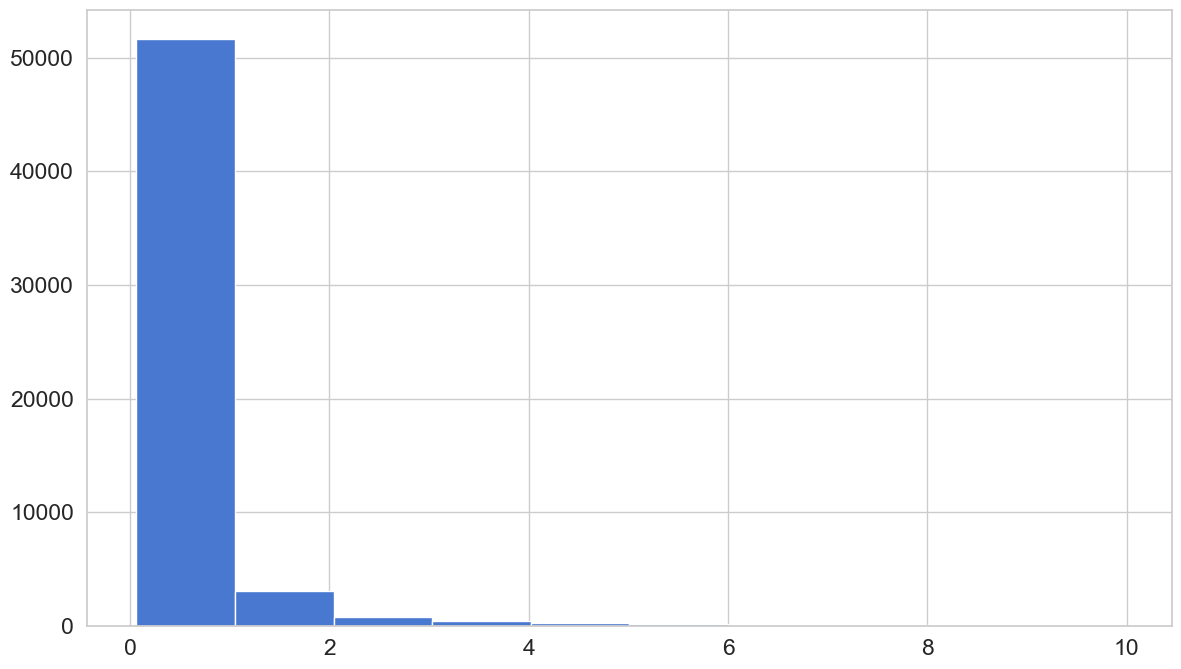

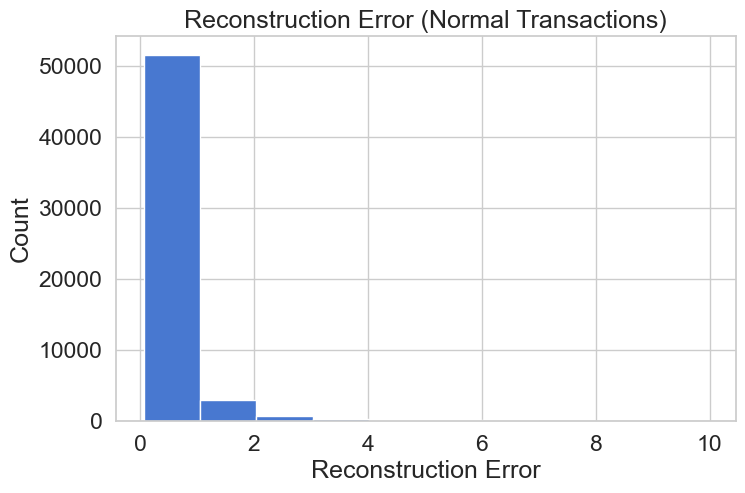

In [29]:
fig = plt.figure(figsize=(8,5))
ax = fig.add_subplot(111)

normal_error_df = error_df[
    (error_df['true_class'] == 0) & 
    (error_df['reconstruction_error'] < 10)
]

ax.hist(normal_error_df.reconstruction_error.values, bins=10)
plt.title("Reconstruction Error (Normal Transactions)")
plt.xlabel("Reconstruction Error")
plt.ylabel("Count")
plt.show()


## Reconstruction error with fraud

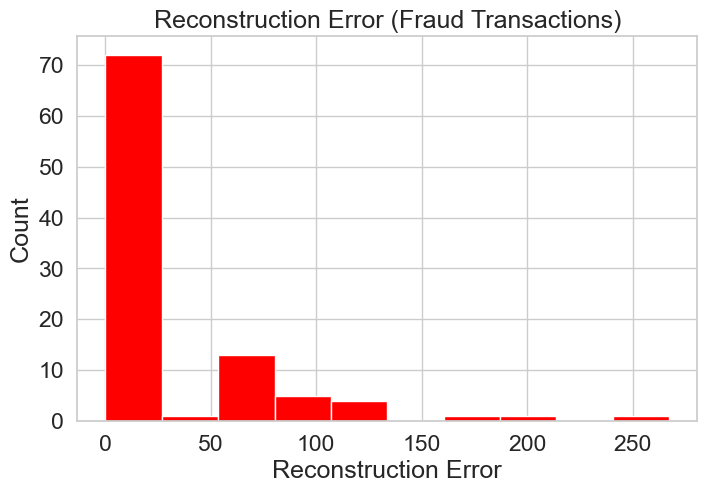

In [30]:
fig = plt.figure(figsize=(8,5))
ax = fig.add_subplot(111)

fraud_error_df = error_df[error_df['true_class'] == 1]

ax.hist(fraud_error_df.reconstruction_error.values, bins=10, color='red')
plt.title("Reconstruction Error (Fraud Transactions)")
plt.xlabel("Reconstruction Error")
plt.ylabel("Count")
plt.show()


In [31]:
from sklearn.metrics import (confusion_matrix, precision_recall_curve, auc,
                             roc_curve, recall_score, classification_report, f1_score,
                             precision_recall_fscore_support)

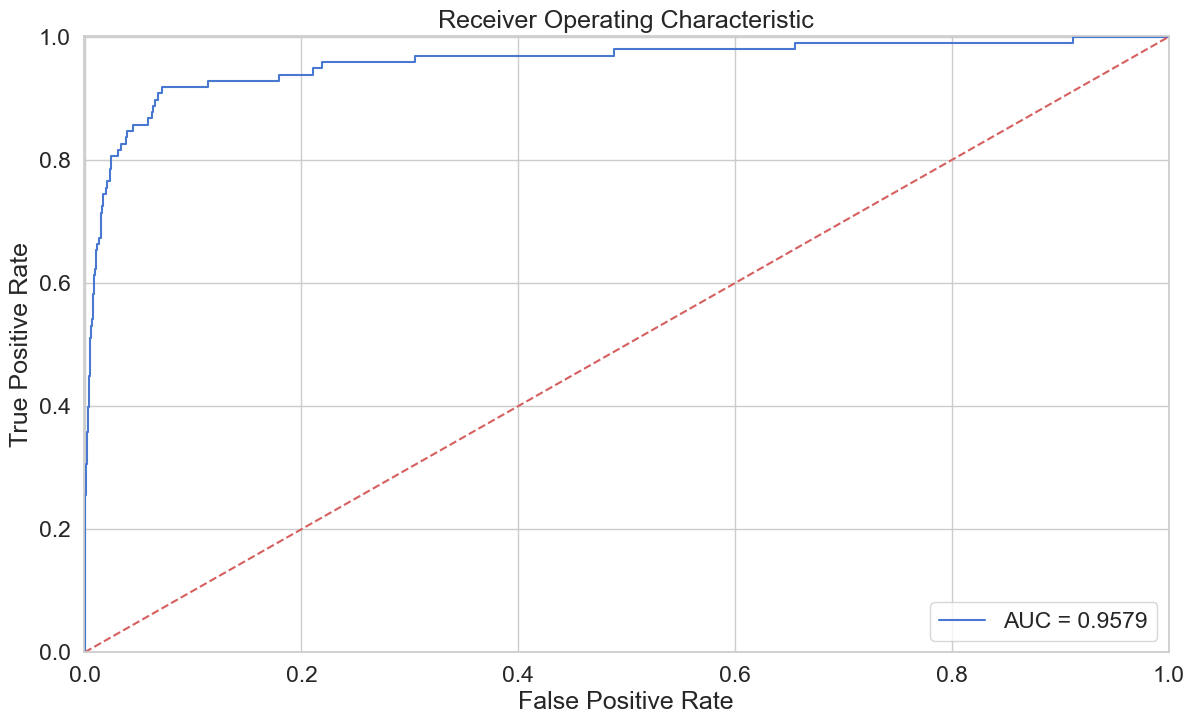

In [32]:
fpr, tpr, thresholds = roc_curve(error_df.true_class, error_df.reconstruction_error)
roc_auc = auc(fpr, tpr)

plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, label='AUC = %0.4f'% roc_auc)
plt.legend(loc='lower right')
plt.plot([0,1],[0,1],'r--')
plt.xlim([-0.001, 1])
plt.ylim([0, 1.001])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show();

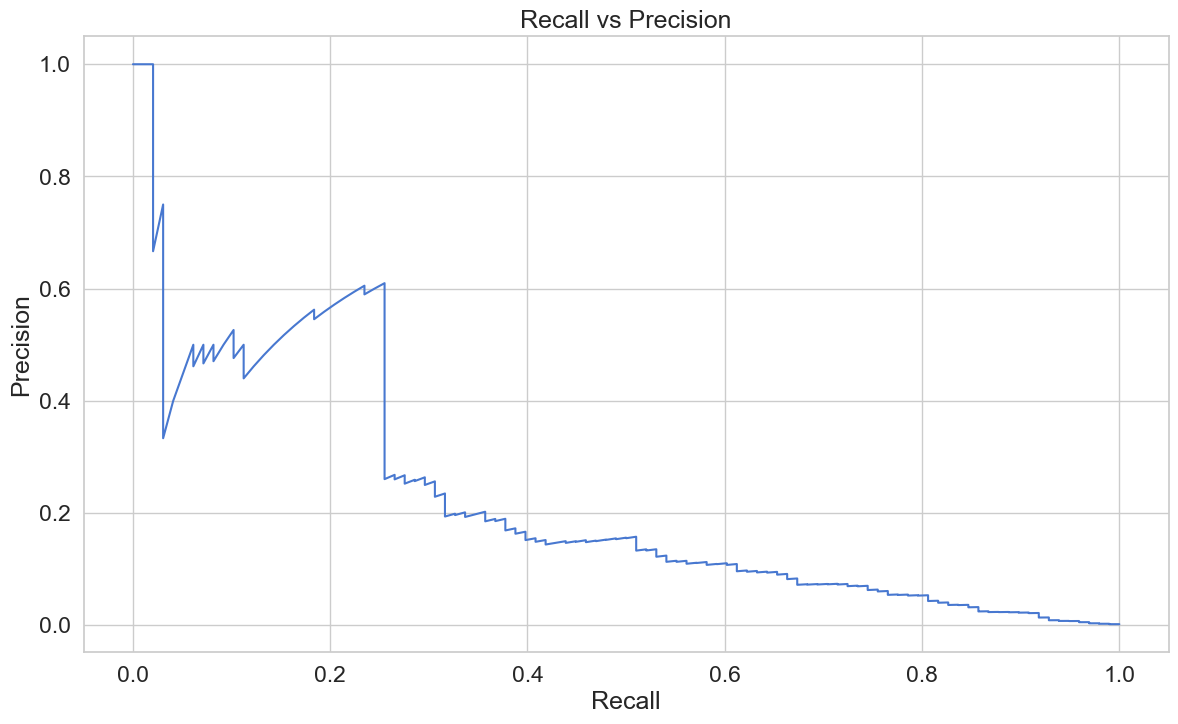

In [33]:
precision, recall, th = precision_recall_curve(error_df.true_class, error_df.reconstruction_error)
plt.plot(recall, precision, 'b', label='Precision-Recall curve')
plt.title('Recall vs Precision')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.show()

A high area under the curve represents both high recall and high precision, where high precision relates to a low false positive rate, and high recall relates to a low false negative rate. High scores for both show that the classifier is returning accurate results (high precision), as well as returning a majority of all positive results (high recall).

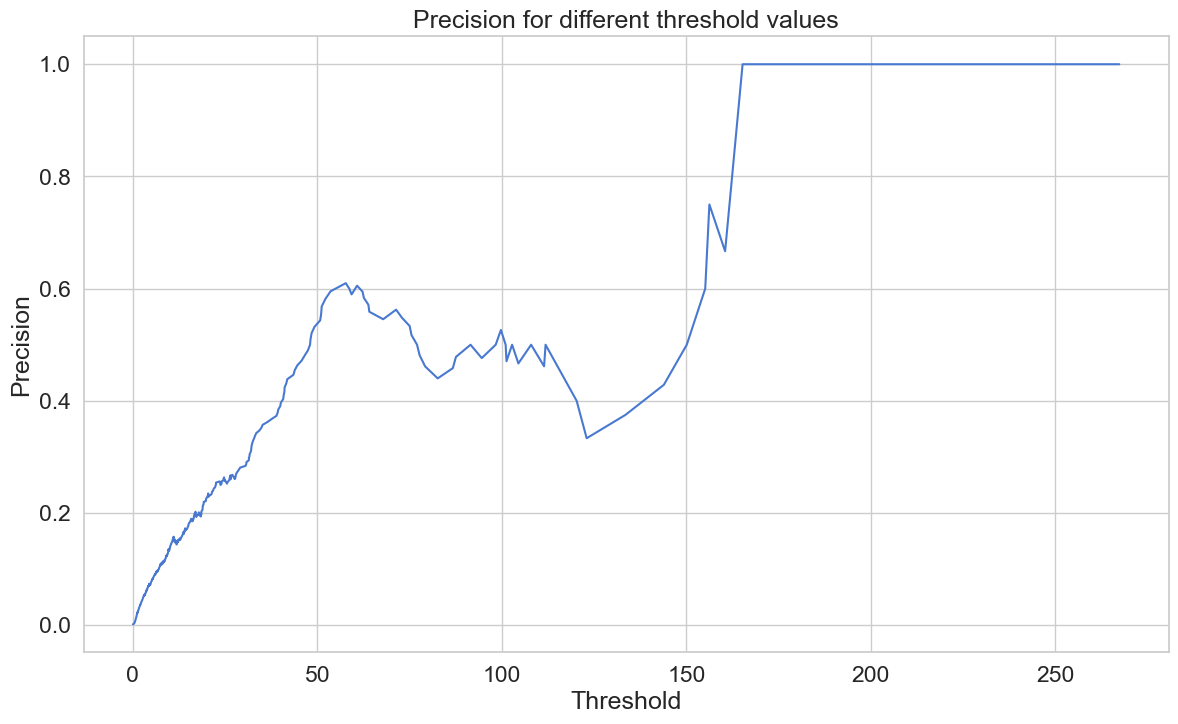

In [34]:
plt.plot(th, precision[1:], 'b', label='Threshold-Precision curve')
plt.title('Precision for different threshold values')
plt.xlabel('Threshold')
plt.ylabel('Precision')
plt.show()

You can see that as the reconstruction error increases our precision rises as well. Let's have a look at the recall:

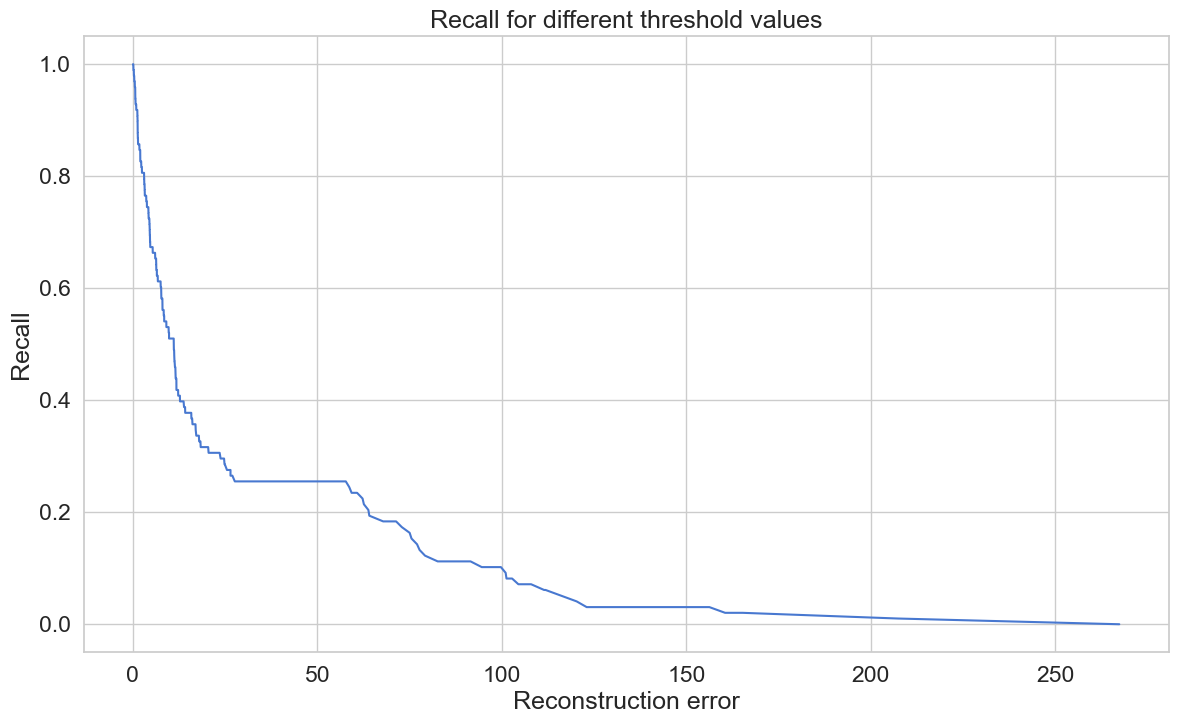

In [35]:
plt.plot(th, recall[1:], 'b', label='Threshold-Recall curve')
plt.title('Recall for different threshold values')
plt.xlabel('Reconstruction error')
plt.ylabel('Recall')
plt.show()

Here, we have the exact opposite situation. As the reconstruction error increases the recall decreases.

# Prediction

Our model is a bit different this time. It doesn't know how to predict new values. But we don't need that. In order to predict whether or not a new/unseen transaction is normal or fraudulent, we'll calculate the reconstruction error from the transaction data itself. If the error is larger than a predefined threshold, we'll mark it as a fraud (since our model should have a low error on normal transactions). Let's pick that value:

In [44]:
threshold = 2.9

In [45]:
print(classification_report(error_df.true_class, y_pred, target_names=LABELS))


              precision    recall  f1-score   support

      Normal       1.00      0.97      0.99     56864
       Fraud       0.05      0.81      0.10        98

    accuracy                           0.97     56962
   macro avg       0.53      0.89      0.54     56962
weighted avg       1.00      0.97      0.99     56962



In [46]:
precision, recall, fscore, _ = precision_recall_fscore_support(
    error_df.true_class,
    y_pred,
    average='binary'
)

print("Precision:", precision)
print("Recall:", recall)
print("F1-score:", fscore)


Precision: 0.050934880722114766
Recall: 0.8061224489795918
F1-score: 0.09581564584596726


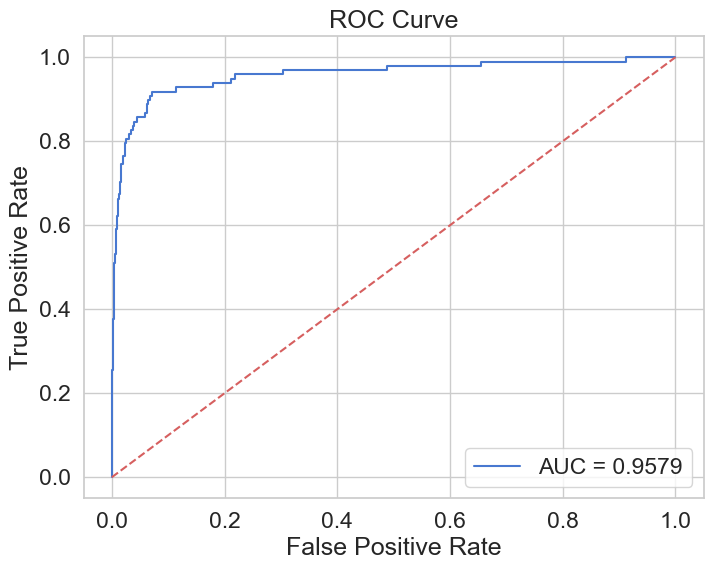

In [47]:
fpr, tpr, thresholds = roc_curve(error_df.true_class, error_df.reconstruction_error)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8,6))
plt.plot(fpr, tpr, label='AUC = %0.4f' % roc_auc)
plt.plot([0,1],[0,1],'r--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.show()


And see how well we're dividing the two types of transactions:

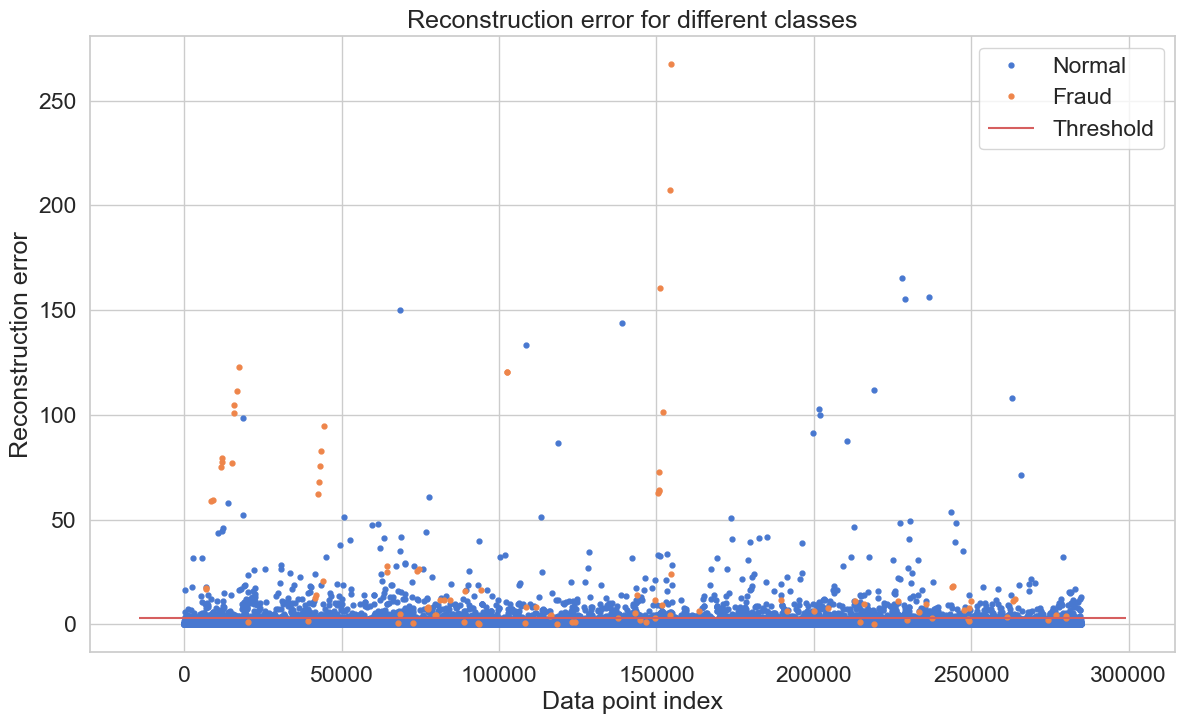

In [48]:
groups = error_df.groupby('true_class')
fig, ax = plt.subplots()

for name, group in groups:
    ax.plot(group.index, group.reconstruction_error, marker='o', ms=3.5, linestyle='',
            label= "Fraud" if name == 1 else "Normal")
ax.hlines(threshold, ax.get_xlim()[0], ax.get_xlim()[1], colors="r", zorder=100, label='Threshold')
ax.legend()
plt.title("Reconstruction error for different classes")
plt.ylabel("Reconstruction error")
plt.xlabel("Data point index")
plt.show();

I know, that chart might be a bit deceiving. Let's have a look at the confusion matrix:

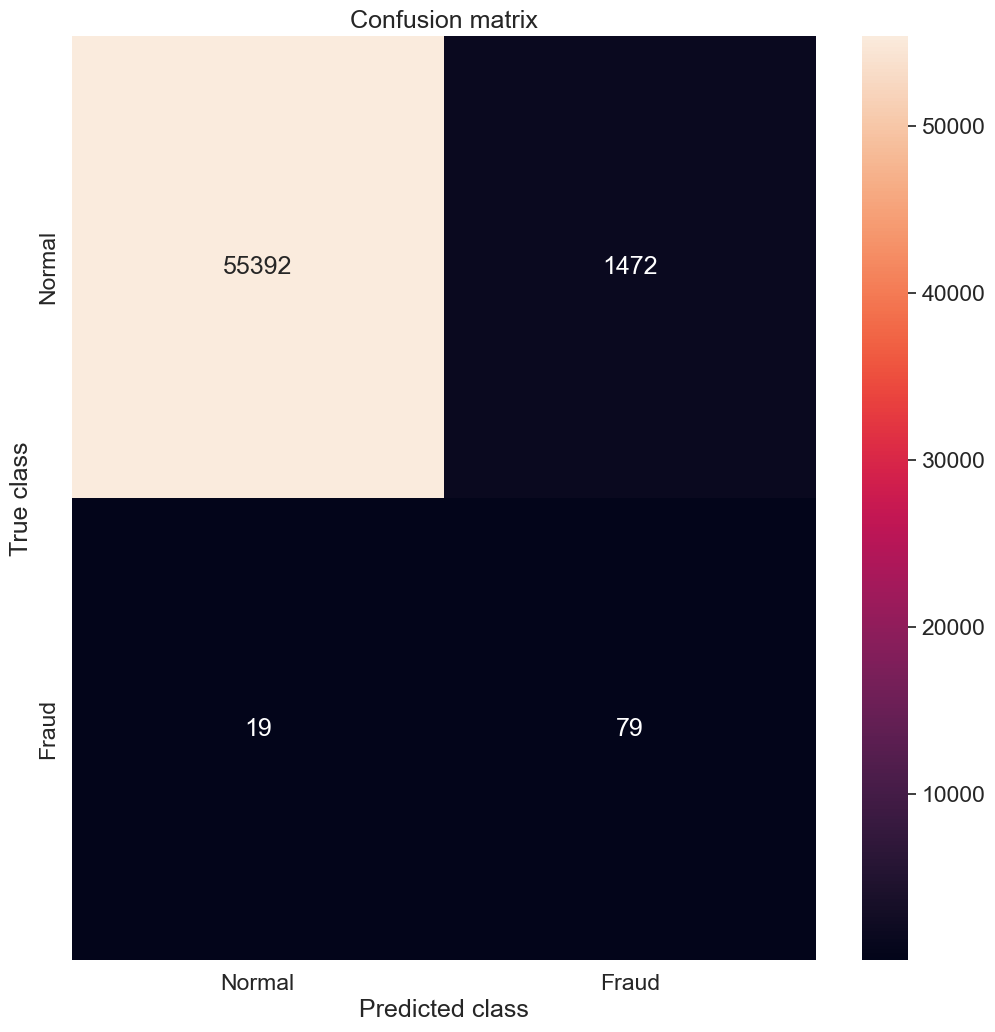

In [49]:
y_pred = [1 if e > threshold else 0 for e in error_df.reconstruction_error.values]
conf_matrix = confusion_matrix(error_df.true_class, y_pred)

plt.figure(figsize=(12, 12))
sns.heatmap(conf_matrix, xticklabels=LABELS, yticklabels=LABELS, annot=True, fmt="d");
plt.title("Confusion matrix")
plt.ylabel('True class')
plt.xlabel('Predicted class')
plt.show()

# Conclusion
In this project, we built an Autoencoder-based anomaly detection model to identify fraudulent credit card transactions. The autoencoder was trained only on normal transactions, allowing it to learn their underlying patterns and reconstruct them accurately. During testing, we calculated the reconstruction error for both normal and fraudulent transactions.

From the analysis:

Normal transactions showed very low reconstruction error, meaning the autoencoder learned their structure well.

Fraudulent transactions produced much higher errors, showing they deviate from the learned normal pattern.

By selecting an appropriate threshold, we were able to classify transactions as fraud or normal.

The confusion matrix showed that most fraud cases were successfully detected, which is expected for anomaly detection systems.

The model does generate some false positives, but this is common in fraud detection — detecting fraud is more important than occasionally flagging a normal transaction.

Overall, the autoencoder successfully captured the distribution of legitimate transactions and demonstrated its capability to identify anomalies (frauds) based on reconstruction error. With further tuning of the threshold and additional post-processing, the model can be made suitable for real-world fraud detection applications.